Section 1: Install and import dependencies

In [ ]:
%pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.layers import Dense, Dropout #type: ignore
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,KFold,GridSearchCV
from scikeras.wrappers import KerasClassifier #type: ignore
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.impute import SimpleImputer

In [ ]:
dataset_path = "/content/DA_data/rta_data.csv"
data = pd.read_csv(dataset_path)

In [ ]:
print("Dataset Info:\n")
data.info()
# print(data.shape)

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment 

In [ ]:
print("First 5 Rows:")
data.head()

First 5 Rows:


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


Section 2: In depth inspection of the dataset in order to decide what kind of preprocessing we need to apply

In [ ]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
missing_values

Missing Values:


,0
Time,0
Day_of_week,0
Age_band_of_driver,0
Sex_of_driver,0
Educational_level,741
Vehicle_driver_relation,579
Driving_experience,829
Type_of_vehicle,950
Owner_of_vehicle,482
Service_year_of_vehicle,3928


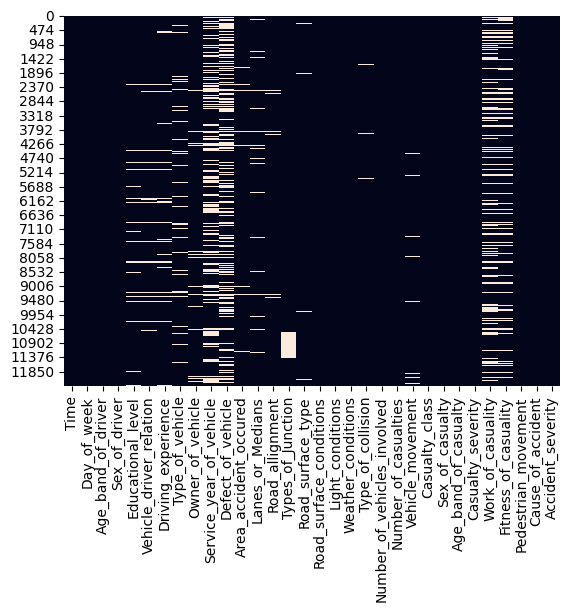

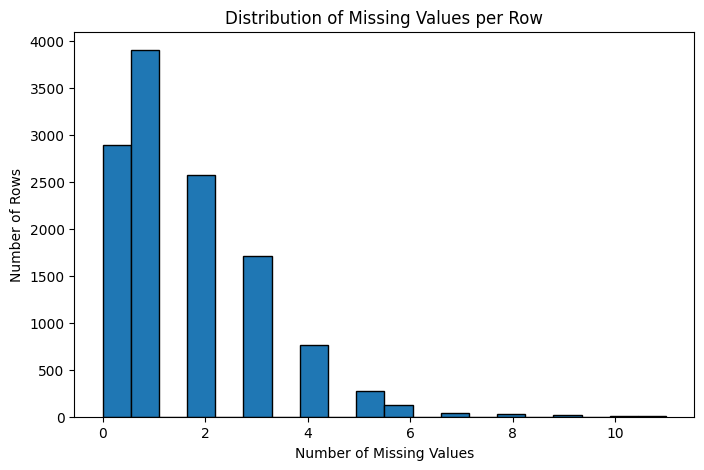

In [ ]:
# Visually representing missing data patterns
sns.heatmap(data.isnull(), cbar=False)
plt.show()

# Plot the distribution of missing values
missing_per_row = data.isnull().sum(axis=1)
plt.figure(figsize=(8, 5))
plt.hist(missing_per_row, bins=20, edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.show()

In [ ]:
# Target variable count
target_count = data["Accident_severity"].value_counts()
print("Target count")
target_count

Target count


,count
Accident_severity,
Slight Injury,10415
Serious Injury,1743
Fatal injury,158


In [ ]:
# Summary statistics for numeric columns
numerical_columns = data.select_dtypes(include=["float", "int"]).columns
print("Numeric Columns Descriptive Stats:")
data[numerical_columns].describe()

Numeric Columns Descriptive Stats:


,Number_of_vehicles_involved,Number_of_casualties
count,12316.000000,12316.000000
mean,2.040679,1.548149
std,0.688790,1.007179
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,7.000000,8.000000


In [ ]:
# Summary statistics for categorical columns
categorical_columns = data.select_dtypes(include=["object"]).columns
print("Categorical Descriptive Stats:")
data[categorical_columns].describe()

Categorical Descriptive Stats:


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
count,12316,12316,12316,12316,11575,11737,11487,11366,11834,8388,...,12008,12316,12316,12316,12316,9118,9681,12316,12316,12316
unique,1074,7,5,3,7,4,7,17,4,6,...,13,4,3,6,4,7,5,9,20,3
top,15:30:00,Friday,18-30,Male,Junior high school,Employee,5-10yr,Automobile,Owner,Unknown,...,Going straight,Driver or rider,Male,na,3,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
freq,120,2041,4271,11437,7619,9627,3363,3205,10459,2883,...,8158,4944,5253,4443,7076,5903,9608,11390,2263,10415


Section 3: Pre processing phase

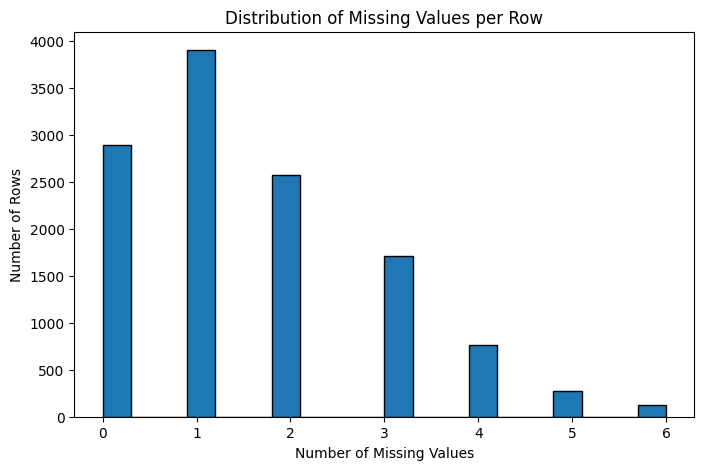

In [ ]:
# Define the threshold to remove instances that have missing values (20% missing allowed)
missing_threshold = 0.2
max_missing_values = int(len(data.columns) * missing_threshold)
data = data.dropna(thresh=len(data.columns) - max_missing_values)
# Count missing values per row
missing_per_row = data.isnull().sum(axis=1)

plt.figure(figsize=(8, 5))
plt.hist(missing_per_row, bins=20, edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.show()


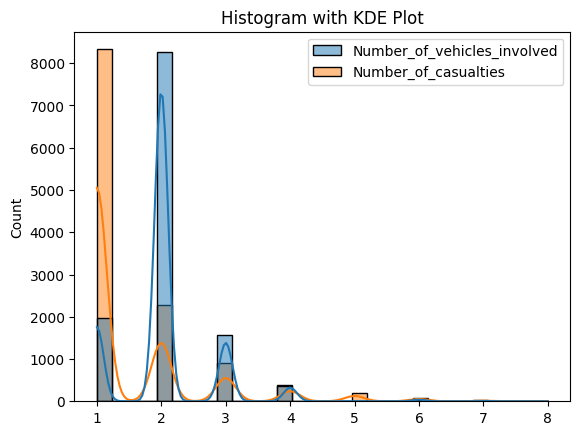

In [ ]:
# Check if the dataset it normally distributed, skewed, or categorical like numeric
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data[numerical_columns], kde=True, bins=30)
plt.title("Histogram with KDE Plot")
plt.show()



In [ ]:
# Substituting null values for numerical data with median
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

In [ ]:
# Substituting null values for categorical data appropriately
# 1. Impute 'Defect_of_vehicle' based on 'Type_of_vehicle' (Categorical Mode)
data['Defect_of_vehicle'] = data.groupby('Type_of_vehicle')['Defect_of_vehicle'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown")
)
# 2. Impute Service_year_of_vehicle with Unknown
data['Service_year_of_vehicle'] = data['Service_year_of_vehicle'].fillna('Unknown')
data['Fitness_of_casuality'].fillna(data['Fitness_of_casuality'].mode()[0], inplace=True)
# 3. Mode Imputation for columns with <10% missing values
columns_to_mode_impute = ['Type_of_vehicle', 'Types_of_Junction', 'Driving_experience']
mode_imputer = SimpleImputer(strategy='most_frequent')
data[columns_to_mode_impute] = mode_imputer.fit_transform(data[columns_to_mode_impute])
# 5. Drop columns that don't have use with a lot of missing values
data = data.drop(columns=['Work_of_casuality'])

<ipython-input-17-21d518e99b85>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Fitness_of_casuality'].fillna(data['Fitness_of_casuality'].mode()[0], inplace=True)


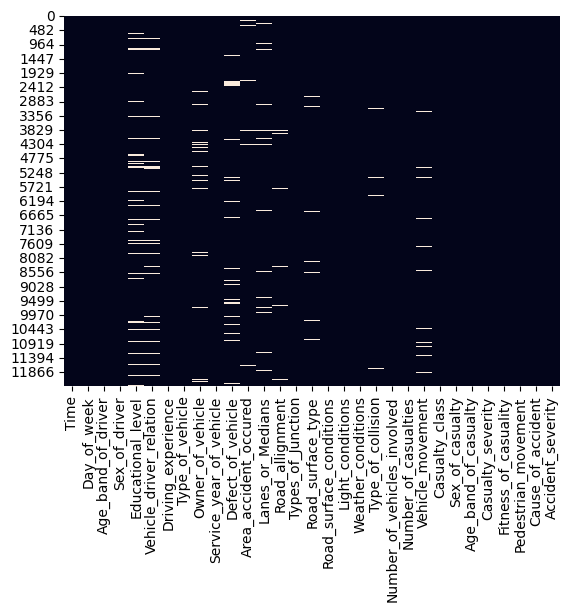

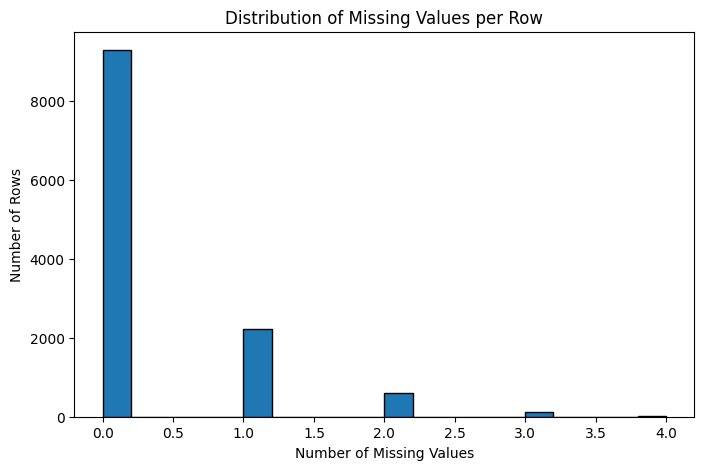

In [ ]:
sns.heatmap(data.isnull(), cbar=False)
plt.show()
print ("\n")
# Count missing values per row
missing_per_row = data.isnull().sum(axis=1)

# Plot the distribution of missing values
plt.figure(figsize=(8, 5))
plt.hist(missing_per_row, bins=20, edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.show()


In [ ]:
categorical_columns = data.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [ ]:
var_thresholder = VarianceThreshold(threshold=0.05)
X_low_var = var_thresholder.fit_transform(data.drop(columns=["Accident_severity"]))
low_variance_columns = data.drop(columns=["Accident_severity"]).columns[~var_thresholder.get_support()]
print("\nLow-Variance Columns Removed:\n", low_variance_columns)
data = data.drop(columns=low_variance_columns)


Low-Variance Columns Removed:
 Index(['Fitness_of_casuality'], dtype='object')


In [ ]:
target_column = "Accident_severity"
X = data.drop(columns=[target_column])
y = data[target_column]

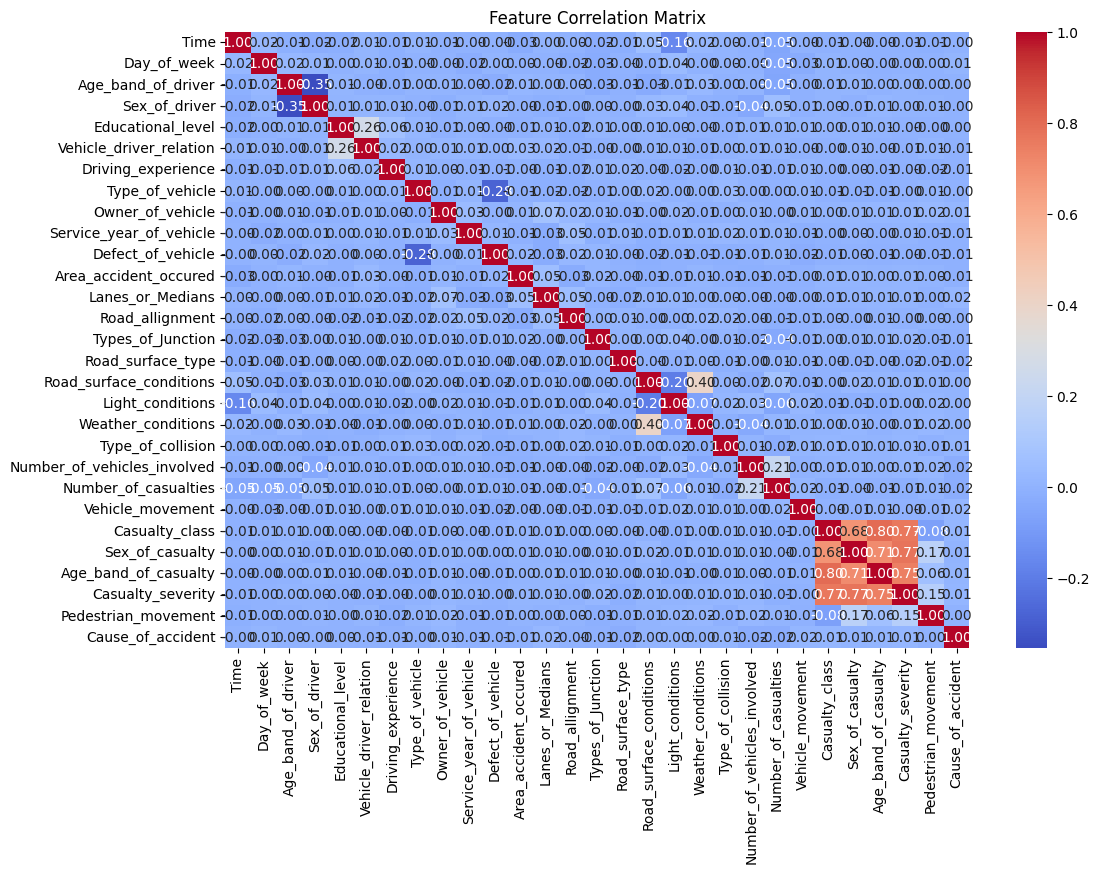

In [ ]:
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# Identify and remove highly correlated features
high_corr_pairs = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
                   if col1 != col2 and abs(correlation_matrix[col1][col2]) > 0.9]
high_corr_features = set(pair[1] for pair in high_corr_pairs)
print("\nHighly Correlated Features Removed:\n", high_corr_features)
X = X.drop(columns=high_corr_features)


Highly Correlated Features Removed:
 set()


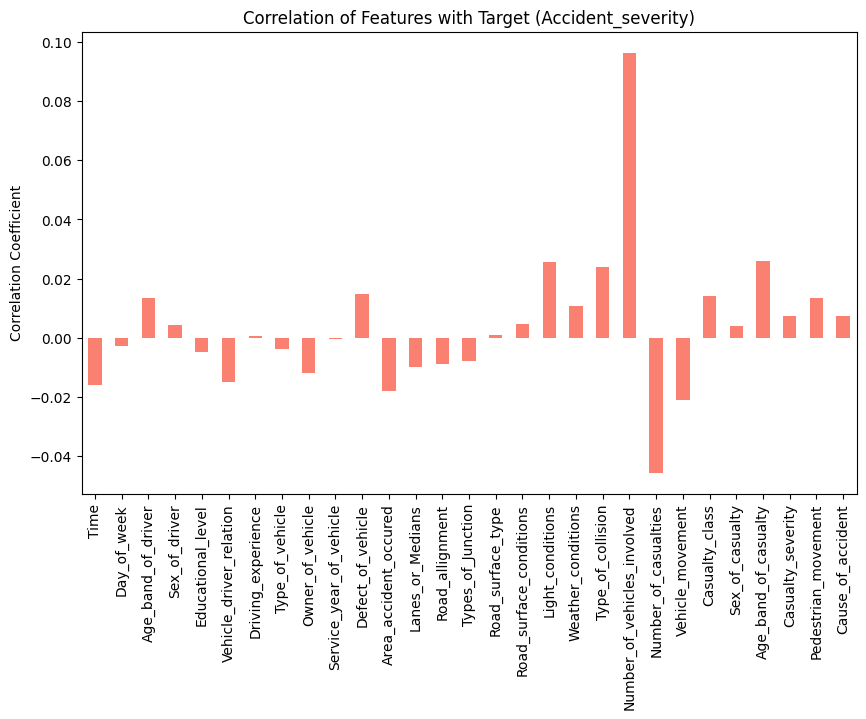

In [ ]:
target_corr = X.corrwith(y)
# print("\nCorrelation with Target 'Accident_severity':\n", target_corr)
plt.figure(figsize=(10, 6))
target_corr.plot(kind='bar', color='salmon')
plt.title("Correlation of Features with Target (Accident_severity)")
plt.ylabel("Correlation Coefficient")
plt.show()


In [ ]:
mutual_info = mutual_info_classif(X, y)
mi_series = pd.Series(mutual_info, index=X.columns)

# Print Mutual Information between features and the target
print("\nMutual Information between Features and Target:\n", mi_series)
target_corr = X.corrwith(y)
print("\nCorrelation with Target 'Accident_severity':\n", target_corr)


Mutual Information between Features and Target:
 Time                           0.070509
Day_of_week                    0.000364
Age_band_of_driver             0.000000
Sex_of_driver                  0.001544
Educational_level              0.000000
Vehicle_driver_relation        0.001000
Driving_experience             0.004103
Type_of_vehicle                0.004156
Owner_of_vehicle               0.000000
Service_year_of_vehicle        0.002386
Defect_of_vehicle              0.005087
Area_accident_occured          0.000000
Lanes_or_Medians               0.002418
Road_allignment                0.000743
Types_of_Junction              0.009815
Road_surface_type              0.000000
Road_surface_conditions        0.003635
Light_conditions               0.006555
Weather_conditions             0.003542
Type_of_collision              0.003989
Number_of_vehicles_involved    0.011739
Number_of_casualties           0.005584
Vehicle_movement               0.000000
Casualty_class                

In [ ]:
# Set a threshold for mutual information
mi_threshold = 0.00

# Select features that have mutual information above the threshold
selected_features = mi_series[mi_series > mi_threshold].index.tolist()

print("\nSelected Features based on Mutual Information:\n", selected_features)
X = X[selected_features]


Selected Features based on Mutual Information:
 ['Time']


In [ ]:
# Over sample the data
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [ ]:
# under sample the data
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

In [ ]:
#Scaling our data since our models are distance based
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Checking the shape of my training and testing set
print("\nTrain-Test Split:\n")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Train-Test Split:

X_train: (21695, 1), X_test: (9298, 1)
y_train: (21695,), y_test: (9298,)


Section 3: Training the Model

In [ ]:
classifier = KNeighborsClassifier()

# Explore different values for my classifier parameters
parameter_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ['uniform', 'distance'],
    "metric": ['euclidean', 'manhattan']
}

print("Tuning hyperparameters for K-Nearest Neighbors...")

# Create GridSearchCV object for classifier
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=parameter_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and cross-validation score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the mean and standard deviation of the cross-validation accuracy for the best model
best_index = grid_search.best_index_
mean_accuracy = grid_search.cv_results_['mean_test_score'][best_index]
std_accuracy = grid_search.cv_results_['std_test_score'][best_index]

print(f"Mean cross-validation accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nK-Nearest Neighbors Model Performance (Test Set - with best hyperparameters):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Tuning hyperparameters for K-Nearest Neighbors...
Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Best cross-validation score: 0.6605
Mean cross-validation accuracy: 0.6605 ± 0.0071

K-Nearest Neighbors Model Performance (Test Set - with best hyperparameters):
Accuracy: 0.6449
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      3099
           1       0.60      0.60      0.60      3099
           2       0.59      0.55      0.57      3100

    accuracy                           0.64      9298
   macro avg       0.64      0.64      0.64      9298
weighted avg       0.64      0.64      0.64      9298



In [ ]:
classifier = GaussianNB()
# Explore different values for my classifier parameters
parameter_grid = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
}

print("Tuning hyperparameters for Naïve Bayes...")

# Create GridSearchCV object for classifier
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=parameter_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and cross-validation score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the mean and standard deviation of the cross-validation accuracy for the best model
best_index = grid_search.best_index_
mean_accuracy = grid_search.cv_results_['mean_test_score'][best_index]
std_accuracy = grid_search.cv_results_['std_test_score'][best_index]

print(f"Mean cross-validation accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nNaïve Bayes Model Performance (Test Set - with best hyperparameters):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Tuning hyperparameters for Naïve Bayes...
Best hyperparameters: {'var_smoothing': 1e-09}
Best cross-validation score: 0.3738
Mean cross-validation accuracy: 0.3738 ± 0.0088

Naïve Bayes Model Performance (Test Set - with best hyperparameters):
Accuracy: 0.3763
              precision    recall  f1-score   support

           0       0.38      0.69      0.49      3099
           1       0.37      0.21      0.27      3099
           2       0.38      0.24      0.29      3100

    accuracy                           0.38      9298
   macro avg       0.38      0.38      0.35      9298
weighted avg       0.38      0.38      0.35      9298



In [ ]:
# Define the model creation function
def create_model(input_shape, num_classes, dropout_rate=0.2, neurons_1=64, neurons_2=32):
    model = Sequential([
        Dense(neurons_1, activation='relu', input_dim=input_shape),
        Dropout(dropout_rate),
        Dense(neurons_2, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Custom wrapper class to make Keras model compatible with scikit-learn
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_shape, num_classes, dropout_rate=0.2, neurons_1=64, neurons_2=32, batch_size=32, epochs=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.neurons_1 = neurons_1
        self.neurons_2 = neurons_2
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        self.model = create_model(self.input_shape, self.num_classes, self.dropout_rate, self.neurons_1, self.neurons_2)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def get_params(self, deep=True):
        return {
            'input_shape': self.input_shape,
            'num_classes': self.num_classes,
            'dropout_rate': self.dropout_rate,
            'neurons_1': self.neurons_1,
            'neurons_2': self.neurons_2,
            'batch_size': self.batch_size,
            'epochs': self.epochs
        }

# Create K-Fold cross-validation splits
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define the hyperparameter grid to search over
param_grid = {
    'dropout_rate': [0.2, 0.3],
    'neurons_1': [64, 128],
    'neurons_2': [32, 64],
    'batch_size': [32, 64],
    'epochs': [10]
}

# Initialize the model and GridSearchCV
input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Use GridSearchCV with K-Fold cross-validation
grid_search = GridSearchCV(
    estimator=KerasClassifierWrapper(input_shape=input_shape, num_classes=num_classes),
    param_grid=param_grid,
    cv=kf,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print best hyperparameters and cross-validation score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 10, 'neurons_1': 128, 'neurons_2': 64}
Best Cross-Validation Accuracy: 0.4148
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Test Set Performance:
Accuracy: 0.3999
              precision    recall  f1-score   support

           0       0.50      0.37      0.42      3099
           1       0.39      0.24      0.30      3099
           2       0.36      0.59      0.45      3100

    accuracy                           0.40      9298
   macro avg       0.42      0.40      0.39      9298
weighted avg       0.42      0.40      0.39      9298

